# Analysing transit systems with Python
This notebook shows a brief analysis of the transit network of Bagé, RS, Brazil. We oslo code an optimization algorithm to maximize accessibility by bus.

In [1]:
import pickle
import geopandas as gpd
import numpy as np
from tools.gtfs_networks import *
import osmnx as ox
import matplotlib.pyplot as plt

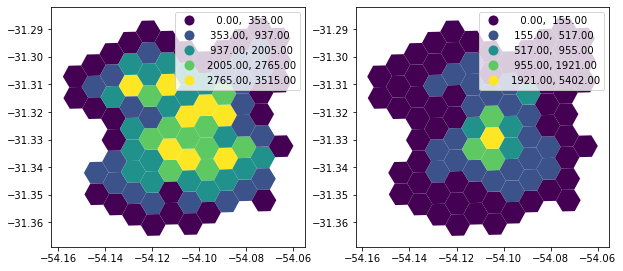

In [2]:
#first, we load an hexagonal grid with population and jobs in the urban region of Bagé - Brazil
grid = gpd.read_file('test_data/bage_shape')
#plotting the grid
fig,axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
#plotting population
grid.plot(column='population', ax = axs[0], legend = True,
                      scheme = 'fisherjenks')
#plotting jobs
grid.plot(column='jobs', ax = axs[1],legend = True,
                      scheme = 'fisherjenks')
plt.show()

# Creating a transit graph

Transit networks strongly interact with pedestrian networks, so to accurately model the system, we first need the pedestrian network as a graph. We do this through the OSMnx library. *Boeing, G. (2017). OSMnx: New methods for acquiring, constructing, analyzing, and visualizing complex street networks. Computers, Environment and Urban Systems, 65, 126–139. https://doi.org/10.1016/j.compenvurbsys.2017.05.004*


First, we take the polygon comprising the area of Bagé to extract the walk network directly from OpenStreetMap

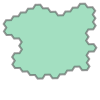

In [3]:
poly = grid.unary_union
poly

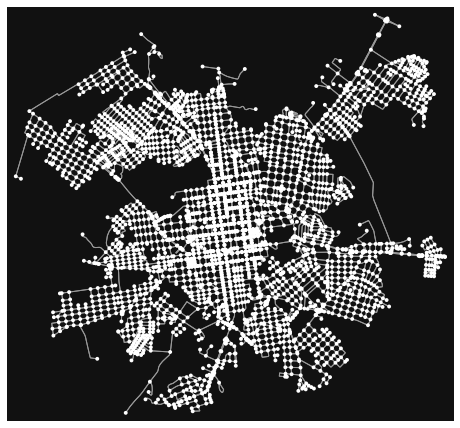

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
#fetching the walk network as an oriented graph
Walk_Graph = ox.graph_from_polygon(poly, network_type = 'walk')
#estimating walk time per edge
walkspeed = 3.5 #km/h
for e in Walk_Graph.edges:
    Walk_Graph.edges[e]['time_sec'] = Walk_Graph.edges[e]['length']/walkspeed*3.6
ox.plot_graph(Walk_Graph)

Now we can retrieve the bus routes from the Bage GTFS database and convert them to graphs as well. This is done through the convertion of route schedules and stop locations to oriented graphs. Most of the code to retrieve bus routes as graphs was devoloped by myself, but to load GTFS data as DataFrames, the gtfs toolkit for Python was used. 

In [5]:
bus_routes = get_transit_lines_as_graphs('test_data/GTFS_Bage.zip')
bus_routes

The routes come as a list with a graph per route. To form the final graph, where transit lines are appended to the walk graph, we loop through the routes.

In [6]:
# first we associate the stop locations with the closest nodes of the pedestrian network with 100m tolerance
Transit_Graph = Walk_Graph.copy()
get_closest_nodes(Transit_Graph, bus_routes, tol = 100)

# Each bus route has a specific headway (time between buses)
# To account for embarking time, we stipulate that users have 
# to wait an average of headway/2
for r in bus_routes:
    add_bus_line(Transit_Graph,r, r.graph['route_id'], headway = r.graph['headway'])

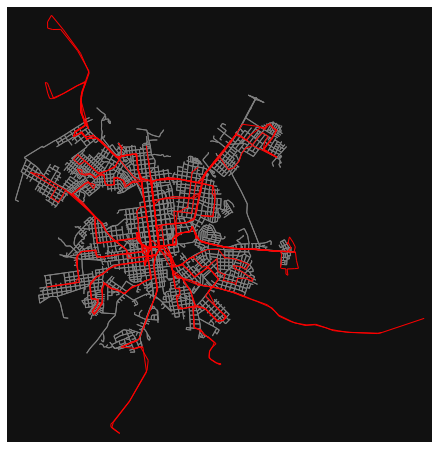

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [7]:
# color transit lines red
colors = ['grey' if m is None else 'r' for e1, e2, m in Transit_Graph.edges(data='mode')]
ox.plot_graph(Transit_Graph, edge_color = colors, node_size=0)

# Calculating accessibility
I have previously developed some scripts for accessibility analysis and fast routing in `accessibility.py` for ease of understanding, I will not transcribe the functions in this notebook, we will only retrieve the functions from the script:

In [8]:
from tools.accessibility import *
from tools.accessibility_fit import *

In a first approach to the problem, we will calculate how much impact the transit system has for the different regions of the city.

For that, we will first calculate the accessibility of the pedestrian network as the number of **jobs** that can be reached in less than **30 min** (1800 seconds).

In [9]:
acc = calc_accessibility(zones = grid, G = Walk_Graph, opportunities_column = 'jobs',
                         func = cumulative, func_kws = {'t':1800}, random_seed = 42,
                         weight = 'time_sec')

# add the results to the grid
grid['walk_acc'] = acc.values()

Then we calculate the accessibility of the network when the transit routes are added:

In [10]:
# We consider that the user always start from a point in the 
# pedestrian network (node_subset=Walk_Graph)
acc = calc_accessibility(zones = grid, G = Transit_Graph, opportunities_column = 'jobs',
                         func = cumulative, func_kws = {'t':1800}, random_seed = 42,
                          weight = 'time_sec', node_subset=Walk_Graph)

# add the results to the grid
grid['transit_acc'] = acc.values()

In [11]:
grid.head()

,HEX_ID,population,jobs,geometry,walk_acc,transit_acc
0,0,0,0,"POLYGON ((-54.14719 -31.31474, -54.14970 -31.3...",63.000000,63.000000
1,1,720,63,"POLYGON ((-54.13943 -31.31066, -54.14194 -31.3...",312.806667,780.486667
2,2,0,0,"POLYGON ((-54.14742 -31.30694, -54.14993 -31.3...",190.800000,497.600000
3,3,162,0,"POLYGON ((-54.13967 -31.30286, -54.14218 -31.3...",181.653333,245.973333
4,4,227,17,"POLYGON ((-54.13192 -31.29878, -54.13442 -31.3...",83.850000,83.850000


Now we can see the regions that benefit the most from having the transit network in place:

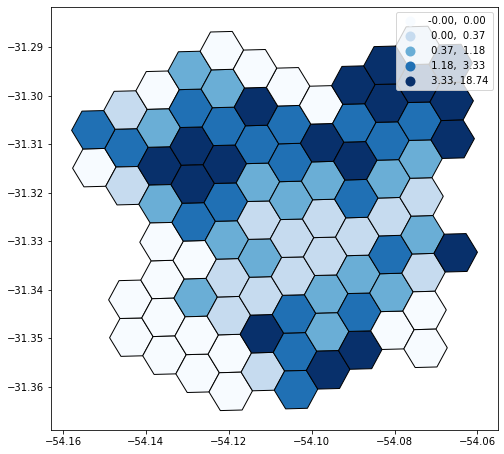

In [12]:
grid['rel_diff'] = (grid['transit_acc']-grid['walk_acc'])/grid['walk_acc']
grid.plot(column='rel_diff', legend = True, figsize=(8,8),
          scheme = 'quantiles',cmap='Blues',edgecolor='k')
plt.show()

The regions that benefit the most are the ones further from the center, as expected. In the last quantile (20% of hexagons that benefit the most), the accessibility of the regions improve 3 to 18 times 

# Assessing the impact of removing each route

We will now assess the impact of removing each transit line

In [13]:
# First, we get the names of the routes
route_names = [r.graph['route_id'] for r in bus_routes]

# We use the average accessibility (weighted by population) as a proxy
baseline = np.average(grid['transit_acc'], weights = grid['population'])

#for each route removed, we check the impact in accessibility
results = []
for rname in route_names:
    Transit_Graph = Walk_Graph.copy()
    get_closest_nodes(Transit_Graph, bus_routes, tol = 100)

    for r in bus_routes:
        # ignore removed route
        if r.graph['route_id'] == rname:
            continue
        add_bus_line(Transit_Graph,r, r.graph['name'], headway = r.graph['headway'])
    acc = calc_accessibility(zones = grid, G = Transit_Graph, opportunities_column = 'jobs',
                             func = cumulative, func_kws = {'t':1800}, random_seed = 42,
                             weight = 'time_sec', node_subset=Walk_Graph)
    
    acc_ = np.average(list(acc.values()), weights = grid['population'])
    
    results.append((( baseline-acc_)/baseline, rname))

In [14]:
#sorted list of impacts
sorted(results,reverse=True)

[(0.13567336620543216, 'ROUTE_c52ab06f-a7dc-4f7d-a0e6-f7085c2d91f0'),
 (0.04039697474864064, 'ROUTE_f8c43c82-faef-4bdf-b77c-dd3bf1858f97'),
 (0.03842633460594367, 'ROUTE_8c8f31bb-c834-40f6-abf1-74148a49b7db'),
 (0.037376135504563764, 'ROUTE_9f63f2c8-ebb2-44b7-8f26-2f6a23ad78f7'),
 (0.02841254738186641, 'ROUTE_cb25e02b-0429-457d-a096-d7c04fd9f9c9'),
 (0.026833881737336456, 'ROUTE_9510e9a2-b447-48e8-b458-e124a2e98bb2'),
 (0.016582242472038565, 'ROUTE_cab0638f-07e4-418f-a94a-1f2cc5185ee9'),
 (0.006055947775915733, 'ROUTE_55c30c67-eb42-45a7-a78e-16a8e662f946'),
 (0.0023727648626362357, 'ROUTE_6ba2a61d-9958-4222-881a-e618906f5574'),
 (0.0016641842484258606, 'ROUTE_bdd56bc6-216a-4620-93c8-943a2474529c'),
 (0.0006817086497130996, 'ROUTE_e2a4fdf6-1a7b-49aa-8fcb-58666d928924'),
 (0.0002141523297979246, 'ROUTE_65733086-3bbd-4eb7-9fa2-fcc12ce1500c'),
 (1.837462821442509e-05, 'ROUTE_e28d7d6f-824c-4fb2-a0df-e5d9bf7eb022'),
 (0.0, 'ROUTE_9806be1d-00cf-49bf-8038-ab285f3ecc27'),
 (0.0, 'ROUTE_7c675812

Interestingly, the impact of the removal of a single route seems minute, lowering the accessibility of the system by less than 2% in the worst case. This points to some level of redundancy in the system which makes it more resilient. 

Some routes have very mild impacts on the system, but this is not to say thet they should be extinguished, since people with reduced mobility might still need these routes. On the other hand, some routes like `55c30c67` have a much larger impact on the system than most others, so the prevention of disruptions in this route is essential to the opperation of the system.

# Optimizing the allocation of buses

Even though assessing the impact of the removal of routes is an interesting proxy to evaluate route importance, bus routes interact between one another, so the problem of best allocating new buses tends to become very complex even for relatively small cities as Bagé.

Given this situation, we will implement a metaheuristic to optimize the allocation of buses.

## Proposed problem

Suppose we have the following problem: The city acquires **15** new buses to opperate the system with higher frequencies, improving the accessibility of the population. What is the best way to allocate these buses in the existing routes?

First, we estimate the number of buses opperating in the system before the acquisition, given the headways and cycle times of each route

In [15]:
def get_buses_per_route(routes):
    buses={}
    for L in routes:
        buses[L.graph['route_id']]=ceil(L.graph['cycle_time']/L.graph['headway'])
    return buses
buses_per_route = get_buses_per_route(bus_routes)
buses_per_route

{'ROUTE_cab0638f-07e4-418f-a94a-1f2cc5185ee9': 2,
 'ROUTE_9f63f2c8-ebb2-44b7-8f26-2f6a23ad78f7': 2,
 'ROUTE_e28d7d6f-824c-4fb2-a0df-e5d9bf7eb022': 2,
 'ROUTE_65733086-3bbd-4eb7-9fa2-fcc12ce1500c': 2,
 'ROUTE_6ba2a61d-9958-4222-881a-e618906f5574': 1,
 'ROUTE_c52ab06f-a7dc-4f7d-a0e6-f7085c2d91f0': 3,
 'ROUTE_25108c07-b4c2-4bfe-90dd-84aee022354c': 1,
 'ROUTE_7c675812-e0a1-4759-97b8-e73fe2847631': 1,
 'ROUTE_8c8f31bb-c834-40f6-abf1-74148a49b7db': 2,
 'ROUTE_9806be1d-00cf-49bf-8038-ab285f3ecc27': 1,
 'ROUTE_bdd56bc6-216a-4620-93c8-943a2474529c': 2,
 'ROUTE_e2a4fdf6-1a7b-49aa-8fcb-58666d928924': 2,
 'ROUTE_cb25e02b-0429-457d-a096-d7c04fd9f9c9': 2,
 'ROUTE_55c30c67-eb42-45a7-a78e-16a8e662f946': 2,
 'ROUTE_f8c43c82-faef-4bdf-b77c-dd3bf1858f97': 2,
 'ROUTE_9510e9a2-b447-48e8-b458-e124a2e98bb2': 1}

In [16]:
#total buses
sum(buses_per_route.values())

28

Now we create the metaheuristic for allocation. We will allocate buses through a Genetic Algorithm trying to maximize the accessibility of the system with the buses added.

The first approach is to define allocation of buses through a "gene". We define a gene as a sequence of cells (each cell is a bus) denoting the routes to allocate each bus. In our case, since we have 15 buses to allocate, we will have a genome of size 15 (a list of size 15). The more frequently a given route appears in the genome, the more buses will be assigned to it as shown in the figure below.

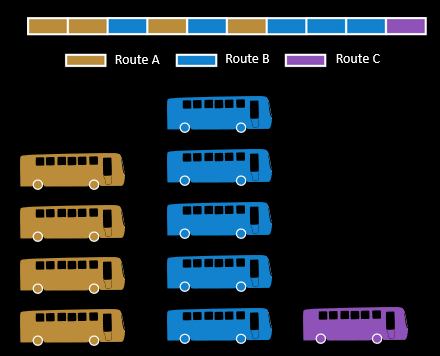

In [17]:
# First, we define a function to assign buses from a gene sequence.
def assign_buses(routes,bus_gene,fixed_buses=None):
    fixed_buses = fixed_buses.copy()
    if fixed_buses is None:
        fixed_buses={L.graph['route_id']:0 for L in routes}
    for g in bus_gene:
        fixed_buses[g]+=1
    for L in routes:
        # if there are any buses asigned
        if fixed_buses[L.graph['route_id']]!=0:
            L.graph['headway']=ceil(L.graph['cycle_time']/fixed_buses[L.graph['route_id']])
        else:
            #large number - in practice, disable route
            L.graph['headway']=1e30 
    return fixed_buses

The next step is to define a function to evaluate the performance of a given gene sequence so selection can occur. In our case, we will define performance as the average accessibility to jobs in 1h weighted by the population. As was done previously.

In [18]:
def performance_check(s, routes, G, gdf, buses=None):
    #copy the routes to avoid losing the original
    routes = [L.copy() for L in routes]
    #assign new buses
    bs=assign_buses(routes,s,buses)
    #copy graph to avoid losing the original
    Gtransit=G.copy()
    for L in routes:
        add_bus_line(Gtransit,L,L.graph['name'],headway=L.graph['headway'])
    #suppress warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        acc=calc_accessibility(gdf,Gtransit,opportunities_column='jobs',
                               func=cumulative,func_kws={'t':1800},
                               weight='time_sec', random_seed=1,
                               node_subset=G.nodes)
    #return the average
    return np.average(list(acc.values()),weights=gdf['population'])

Now we define the three pillars of the Genetic Algorithm: **selection**, **crossover** and **mutation**. 

**selection** will be defined as a tournament between **k** members of the population

In [19]:
def selection(pop, scores, k=3):
    s_ix = random.randint(0,len(pop)-1)
    for ix in np.random.randint(0, len(pop), k-1):
        # perform a tournament
        if scores[ix] > scores[s_ix]:
            s_ix = ix
    return pop[s_ix]


    


**crossover** will be crossing the genes of two tournament winners pivoting in a single point

In [20]:
def crossover(gene1,gene2,rate):
    if random.random()<rate:
        c1,c2=[],[]
        # select a random pivoting point
        pt=random.randint(1, len(gene1)-2)
        #crossover considering the point
        c1 += gene1[:pt] + gene2[pt:]
        c2 += gene2[:pt] + gene1[pt:]
        return [c1, c2]
    else:
        return [gene1,gene2]

**mutation** will randomly flip a position of the gene to a different route, considering the possible choices

In [21]:
def mutation(a,possible,r_mut=.01):
    a=a.copy()
    for i in range(len(a)):
        # check if should perform mutation
        if random.random() < r_mut:
            a[i] = random.choice(possible)
    return a

Finally, we define the code for the Genetic Algorithm. We use some acceleration techniques to improve the speed of processing, the most important of those being `parallel computing` with the `joblib` library.

In [22]:
from joblib import Parallel, delayed

In [23]:
def GA(func,G,routes,gdf,bus_num,population=32,sufix='',buses=None,
       seed=None,crossover_rate=.9,generations=100,r_mut=.01,
       first_guesses=None,save=True,saveeach=1,workers=-1,
       init_density=.3):
    #take baseline value
    bl = func([],routes=routes,G=G,gdf=gdf,
             buses=buses)
    gen=1
    possible = [L.graph['route_id'] for L in routes]
    #start with random population
    random.seed(seed)
    if first_guesses is None:
        first_guesses=[]
    sets=first_guesses
    sets+= [[random.choice(possible) for n in range(bus_num)] 
            for n in range(population-len(first_guesses))]
    
    while True:
        #we evaluate each scenario in parallel processes to accelerate the optimization
        scores = Parallel(n_jobs=workers)(delayed(func)(s,routes=routes,G=G,gdf=gdf,
                                                        buses=buses)
                                          for s in sets)
        scores = [s-bl for s in list(scores)]
            
        top_choices = [selection(sets,scores) for _ in range(population)]
        if gen>generations:break
        #do crossover
        set_dict = {n:s for n,s in zip(range(len(sets)),sets)}
        sets = []
        for i0 in range(0, population, 2):
            # get selected parents in pairs
            p1, p2 = top_choices[i0], top_choices[i0+1]
            # crossover
            for c in crossover(p1, p2, crossover_rate):
                # mutation
                c=mutation(c,possible, r_mut)
                # store for next generation
                sets.append(c)
        #printing statistics
        if gen<2:
            print(f'gen {gen-1:02d}\ttop: {max(scores):.00f}')
        else:
             print(f'gen {gen-1:02d}\ttop: {max(scores):.00f}',
                   end='\r')
        gen+=1
    print(f'gen {gen-1:03d}\ttop: {max(scores):.00f}',
              end='\n\n')
    return sets,scores

In [24]:
population = 36
generations = 50

get_closest_nodes(Walk_Graph, bus_routes, tol = 100)
sets, scores = GA(performance_check, Walk_Graph, bus_routes, grid, bus_num=15, 
                  buses=buses_per_route, population=population,
                  generations=generations,seed=1)

gen 00	top: 3391
gen 050	top: 4338



In [25]:
print(f'An improvement of {(4338/3391-1)*100:.00f}% in relation to random assignment')

An improvement of 28% in relation to random assignment


The final configuration of the network would be

In [26]:
#get index of maximum score
imax = scores.index(max(scores))
bs = assign_buses(bus_routes, sets[imax], buses_per_route)
bs

{'ROUTE_cab0638f-07e4-418f-a94a-1f2cc5185ee9': 3,
 'ROUTE_9f63f2c8-ebb2-44b7-8f26-2f6a23ad78f7': 3,
 'ROUTE_e28d7d6f-824c-4fb2-a0df-e5d9bf7eb022': 2,
 'ROUTE_65733086-3bbd-4eb7-9fa2-fcc12ce1500c': 2,
 'ROUTE_6ba2a61d-9958-4222-881a-e618906f5574': 1,
 'ROUTE_c52ab06f-a7dc-4f7d-a0e6-f7085c2d91f0': 5,
 'ROUTE_25108c07-b4c2-4bfe-90dd-84aee022354c': 4,
 'ROUTE_7c675812-e0a1-4759-97b8-e73fe2847631': 3,
 'ROUTE_8c8f31bb-c834-40f6-abf1-74148a49b7db': 2,
 'ROUTE_9806be1d-00cf-49bf-8038-ab285f3ecc27': 1,
 'ROUTE_bdd56bc6-216a-4620-93c8-943a2474529c': 2,
 'ROUTE_e2a4fdf6-1a7b-49aa-8fcb-58666d928924': 2,
 'ROUTE_cb25e02b-0429-457d-a096-d7c04fd9f9c9': 2,
 'ROUTE_55c30c67-eb42-45a7-a78e-16a8e662f946': 5,
 'ROUTE_f8c43c82-faef-4bdf-b77c-dd3bf1858f97': 3,
 'ROUTE_9510e9a2-b447-48e8-b458-e124a2e98bb2': 3}